In [3]:
!sudo apt-get install wget

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package wget


https://github.com/psygrammer/cav/blob/master/part4/tensorflow/VGG/Using_Pre-trained_Model_VGG.ipynb<br>
http://www.vlfeat.org/matconvnet/models/beta16/imagenet-vgg-verydeep-19.mat<br>

In [5]:
!wget http://www.vlfeat.org/matconvnet/models/beta16/imagenet-vgg-verydeep-19.mat

/bin/sh: 1: wget: not found


In [6]:
!ls

CNN basic.ipynb     VGG Feature.ipynb  resize image.ipynb
Data loading.ipynb  nets


In [1]:
import scipy.io
import numpy as np
import os
import scipy.misc
import matplotlib.pyplot as plt
import tensorflow as tf

%matplotlib inline

In [2]:
D_DATA_PATH = '/data/model/imagenet-vgg-verydeep-19.mat'
D_IMG_FILENAME = 'train/apple_pie/100605.jpg'
D_IMG_PATH = '/data/nv_dlcontest_dataset/'

## Model loading & check

In [76]:
data = scipy.io.loadmat(D_DATA_PATH)

In [77]:
data.keys()

['layers',
 '__header__',
 '__globals__',
 'classes',
 '__version__',
 'normalization']

## get nomalized data

In [78]:
type(data['normalization'])

numpy.ndarray

In [79]:
data['normalization'].ndim

2

In [80]:
len(data['normalization'][0][0][0])

224

In [81]:
mean = data['normalization'][0][0][0]

In [82]:
mean.ndim

3

In [83]:
mean

array([[[ 123.68 ,  116.779,  103.939],
        [ 123.68 ,  116.779,  103.939],
        [ 123.68 ,  116.779,  103.939],
        ..., 
        [ 123.68 ,  116.779,  103.939],
        [ 123.68 ,  116.779,  103.939],
        [ 123.68 ,  116.779,  103.939]],

       [[ 123.68 ,  116.779,  103.939],
        [ 123.68 ,  116.779,  103.939],
        [ 123.68 ,  116.779,  103.939],
        ..., 
        [ 123.68 ,  116.779,  103.939],
        [ 123.68 ,  116.779,  103.939],
        [ 123.68 ,  116.779,  103.939]],

       [[ 123.68 ,  116.779,  103.939],
        [ 123.68 ,  116.779,  103.939],
        [ 123.68 ,  116.779,  103.939],
        ..., 
        [ 123.68 ,  116.779,  103.939],
        [ 123.68 ,  116.779,  103.939],
        [ 123.68 ,  116.779,  103.939]],

       ..., 
       [[ 123.68 ,  116.779,  103.939],
        [ 123.68 ,  116.779,  103.939],
        [ 123.68 ,  116.779,  103.939],
        ..., 
        [ 123.68 ,  116.779,  103.939],
        [ 123.68 ,  116.779,  103.939],
     

## weights

In [84]:
weights = data['layers'][0]

In [85]:
len(weights)

43

In [86]:
weights[0]

array([[ ([[array([[[[ 0.39416704, -0.08419707, -0.03631314, ..., -0.10720515,
          -0.03804016,  0.04690642],
         [ 0.46418372,  0.03355668,  0.10245045, ..., -0.06945956,
          -0.04020201,  0.04048637],
         [ 0.34119523,  0.09563112,  0.0177449 , ..., -0.11436455,
          -0.05099866, -0.00299793]],

        [[ 0.37740308, -0.07876257, -0.04775979, ..., -0.11827433,
          -0.19008617, -0.01889699],
         [ 0.41810837,  0.05260524,  0.09755926, ..., -0.09385028,
          -0.20492788, -0.0573062 ],
         [ 0.33999205,  0.13363543,  0.02129423, ..., -0.13025227,
          -0.16508926, -0.06969624]],

        [[-0.04594866, -0.11583115, -0.14462094, ..., -0.12290562,
          -0.35782176, -0.27979308],
         [-0.04806903, -0.00658076, -0.02234544, ..., -0.0878844 ,
          -0.3915486 , -0.34632796],
         [-0.04484424,  0.06471398, -0.07631404, ..., -0.12629718,
          -0.29905206, -0.28253639]]],


       [[[ 0.2671299 , -0.07969447,  0.05988

## make tensorflow network

In [92]:
def parseNet(data_path, input_image):
    layers = (
        'conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1',
        
        'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',
        
        'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 
        'conv3_3', 'relu3_3', 'conv3_4', 'relu3_4', 'pool3',
        
        'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 
        'conv4_3', 'relu4_3', 'conv4_4', 'relu4_4', 'pool4',
        
        'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 
        'conv5_3', 'relu5_3', 'conv5_4', 'relu5_4'
    )
    
    data_tmp = scipy.io.loadmat(data_path)
    mean = data_tmp['normalization'][0][0][0]
    mean_pixel = np.mean(mean, axis=(0, 1))
    weights = data_tmp['layers'][0]
    
    net = {}
    current = input_image
    for i, name in enumerate(layers):
        kind = name[:4]
        if kind == 'conv':
            kernels, bias = weights[i][0][0][0][0]
            # matconvnet: weights are [width, height, in_channel, out_channel]
            # tensorflow: weights are [height, width, in_channel, out_channel]
            kernels = np.transpose(kernels, (1, 0, 2, 3))
            bias = bias.reshape(-1)
            current = _conv_layer(current, kernels, bias)
        elif kind == 'relu':
            current = tf.nn.relu(current)
        elif kind == 'pool':
            current = _pool_layer(current)
        net[name] = current
        
    assert len(net) == len(layers)
    
    return net, mean_pixel

def _conv_layer(input, weights, bias):
    conv = tf.nn.conv2d(input, tf.constant(weights), strides=(1, 1, 1, 1), padding='SAME')
    return tf.nn.bias_add(conv, bias)

def _pool_layer(input):
    return tf.nn.max_pool(input, ksize=(1, 2, 2, 1), strides=(1, 2, 2, 1), padding='SAME')

def preprocess(image, mean_pixel):
    return image - mean_pixel

def unprocess(image, mean_pixel):
    return image + mean_pixel

## Image read/write function

In [12]:
def imread(path):
    return scipy.misc.imread(path).astype(np.float)

def imsave(path, img):
    img = np.clip(img, 0, 255).astype(np.uint8)
    scipy.misc.imsave(path, img)

## Model loading and run

In [13]:
VGG_PATH = D_DATA_PATH
IMG_PATH = D_IMG_PATH + D_IMG_FILENAME

D_OUTPUT_FILENAME = 'train_VGG/'
VGG_OUT_PATH = D_IMG_PATH + D_OUTPUT_FILENAME

input_image = imread(IMG_PATH)
shape = (1,) + input_image.shape # (h, w, nch) => (1, h, w, nch)

In [14]:
shape

(1, 512, 512, 3)

[1/4] relu2_1
 Type of 'features' is  <type 'numpy.ndarray'>
 Shape of 'features' is (1, 256, 256, 128)
[2/4] relu3_1
 Type of 'features' is  <type 'numpy.ndarray'>
 Shape of 'features' is (1, 128, 128, 256)
[3/4] relu4_1
 Type of 'features' is  <type 'numpy.ndarray'>
 Shape of 'features' is (1, 64, 64, 512)
[4/4] relu5_4
 Type of 'features' is  <type 'numpy.ndarray'>
 Shape of 'features' is (1, 32, 32, 512)

___.


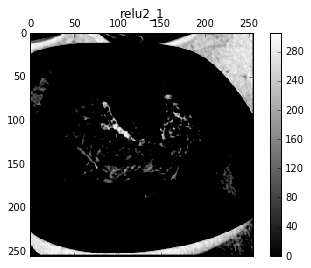

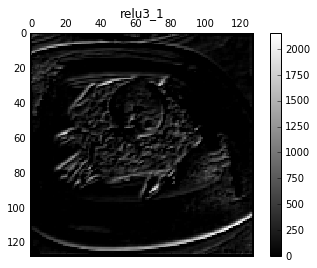

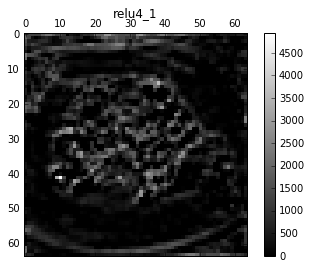

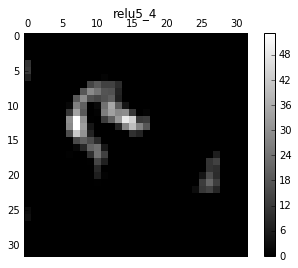

In [96]:
with tf.Graph().as_default(), tf.Session() as sess:
    image = tf.placeholder('float', shape=shape)
    net, mean_pixel = parseNet(VGG_PATH, image)
    input_image_pre = np.array([preprocess(input_image, mean_pixel)])
    
    # layers = all_layers # for all layers
    layers = ('relu2_1', 'relu3_1', 'relu4_1', 'relu5_4')
    
    for i, layer in enumerate(layers):
        print "[%d/%d] %s" % (i+1, len(layers), layer)
        features = net[layer].eval(feed_dict={image: input_image_pre})
        print " Type of 'features' is ", type(features)
        print " Shape of 'features' is %s" % (features.shape,)
        
        # write ndarray to file
        with open(VGG_OUT_PATH + layer, 'w') as f:
            np.save(f, features)
        
        # Plot response
        if 1:
            plt.figure(i+1)
            plt.matshow(features[0, :, :, 0], cmap = plt.cm.gray, fignum=i+1)
            plt.title("" + layer)
            plt.colorbar()

print "\n___."
plt.show()

## Test ndarray data manage

In [38]:
type(net['relu1_1'])

tensorflow.python.framework.ops.Tensor

In [73]:
!ls /data/nv_dlcontest_dataset/train_VGG/ -ls

total 59408
32772 -rw-r--r-- 1 root root 33554528 Sep  3 03:14 relu2_1
16388 -rw-r--r-- 1 root root 16777312 Sep  3 03:14 relu3_1
 8196 -rw-r--r-- 1 root root  8388704 Sep  3 03:14 relu4_1
 2052 -rw-r--r-- 1 root root  2097248 Sep  3 03:14 relu5_4


In [75]:
with open('/data/nv_dlcontest_dataset/train_VGG/relu5_4') as f:
    weight = np.load(f)
    print weight

[[[[  0.          56.53656769   0.         ...,   0.           8.59654522
      0.        ]
   [  0.          67.19132233   0.         ...,   0.           0.           0.        ]
   [  0.          45.00324249   0.         ...,   0.           0.           0.        ]
   ..., 
   [  0.           0.           2.71035337 ...,   0.           7.06639051
      0.        ]
   [  0.           0.           0.         ...,   0.           3.27052498
      2.31801057]
   [  0.           0.           0.         ...,   0.           4.7259779
      0.        ]]

  [[  0.          73.67165375   0.         ...,   0.           0.           0.        ]
   [  0.          58.64225769   0.         ...,   0.           0.           0.        ]
   [  0.          39.51638031   0.         ...,   0.           0.           0.        ]
   ..., 
   [  0.           0.           2.52273512 ...,   0.           0.86076212
      0.        ]
   [  0.           0.           0.         ...,   0.           0.
      4.2131118

## Packaging to Class

In [9]:
import scipy.io
import numpy as np
import os
import scipy.misc
import matplotlib.pyplot as plt
import tensorflow as tf

class image2VGG():
    net = None
    mean_pixel = None
    shape = (1, 512, 512, 3)
    
    vggDataPath = '/data/model/imagenet-vgg-verydeep-19.mat'
    
    def __init__(self, vggDataPath=None):
        
        if vggDataPath is not None:
            self.vggDataPath = vggDataPath
            
        pass
    
    def convertImageDir(self, inputPath, outputPath, model_path=None, forTest=None):
        # /Directory/File
        
        label_list = []
        
        for file in os.listdir(inputPath):
            label_list.append(file)

        # http://stackoverflow.com/questions/3964681/find-all-files-in-directory-with-extension-txt-in-python
        model_path = self.vggDataPath if model_path is None else model_path

        with tf.Graph().as_default(), tf.Session() as sess:
            image = tf.placeholder('float', shape=self.shape)
            self.net, self.mean_pixel = self.parseNet(model_path, image)

            # for each directory
            for i, label in enumerate(label_list):

                _tmp_path = outputPath + os.sep + label
                if not os.path.exists(_tmp_path):
                    os.mkdir(_tmp_path)
                print (label)

                # for each files in directory
                for file2 in os.listdir(inputPath + os.sep + label):
                    input_filename = inputPath + os.sep + label + os.sep + file2
                    output_filename = outputPath + os.sep + label + os.sep + file2
                    
                    output_filename = output_filename[:-(len(output_filename.split('.')[-1])+1)]
                    if os.path.exists(output_filename):
                        continue
                    
                    input_image = self.getImageData(input_filename)
                    
                    if input_image is None:
                        continue
                    
                    input_image_pre = np.array([self.preprocess(input_image, self.mean_pixel)])
                    features = self.net['relu5_4'].eval(feed_dict={image: input_image_pre})
        
                    with open(output_filename, 'w') as f:
                        np.save(f, features)
                    
                    # for test
                    if forTest is not None:
                        break
                
                # for test
                if forTest is not None:
                    break
    
    def convertTestImageDir(self, inputPath, outputPath, model_path=None, forTest=None):
        # /Directory/File
        
        label_list = []

        if not os.path.exists(outputPath):
            os.mkdir(outputPath)
        print (outputPath)

        for file in os.listdir(inputPath):
            label_list.append(file)

        # http://stackoverflow.com/questions/3964681/find-all-files-in-directory-with-extension-txt-in-python
        model_path = self.vggDataPath if model_path is None else model_path

        with tf.Graph().as_default(), tf.Session() as sess:
            image = tf.placeholder('float', shape=self.shape)
            self.net, self.mean_pixel = self.parseNet(model_path, image)

            # for each files in directory
            for file2 in os.listdir(inputPath):
                input_filename = inputPath + os.sep + file2
                output_filename = outputPath + os.sep + file2

                if file2.split('.')[-1] != 'jpg':
                    print ('Skip: ' + file2)
                    continue
                
                output_filename = output_filename[:-(len(output_filename.split('.')[-1])+1)]

                input_image = self.getImageData(input_filename)

                if input_image is None:
                    continue

                input_image_pre = np.array([self.preprocess(input_image, self.mean_pixel)])
                features = self.net['relu5_4'].eval(feed_dict={image: input_image_pre})

                with open(output_filename, 'w') as f:
                    np.save(f, features)

                # for test
                if forTest is not None:
                    break
    
    
    def convertImageFile(self, inputFilenName, outputFileName):
        features = self.convertImage(self.imread(inputFilenName))
        
        with open(outputFileName, 'w') as f:
            np.save(f, features)
    
    def convertImage(self, input_image, model_path=None):
        model_path = self.vggDataPath if model_path is None else model_path

        with tf.Graph().as_default(), tf.Session() as sess:
            image = tf.placeholder('float', shape=shape)
            self.net, self.mean_pixel = parseNet(model_path, image)

            input_image_pre = np.array([self.preprocess(input_image, self.mean_pixel)])
            features = self.net['relu5_4'].eval(feed_dict={image: input_image_pre})
        
        return features
    
    
    
    
    def getImageData(self, data_img_name):
        tmp = self.imread(data_img_name)

        if len(tmp.shape) < 3:
            return None
        
        if tmp.shape[0] != 512 or tmp.shape[1] != 512:
            _tmp = np.zeros((512, 512, 3))

            s_y = (512 - tmp.shape[0])//2
            s_x = (512 - tmp.shape[1])//2
            e_y = s_y + tmp.shape[0]
            e_x = s_x + tmp.shape[1]

            _tmp[s_y:e_y, s_x:e_x, :] = tmp[:, :, :3]
            tmp = _tmp

        return tmp[:, :, :3]

    def dataList(pathName):
        data_img_name = []
        data_label = []

        label_list = []

        for file in os.listdir(pathName):
            label_list.append(file)

        # http://stackoverflow.com/questions/3964681/find-all-files-in-directory-with-extension-txt-in-python
        for i, label in enumerate(label_list):
            for file2 in os.listdir(pathName + os.sep + label):
                data_img_name.append(pathName + os.sep + label + os.sep + file2)
                data_label.append(i)

        return data_img_name, data_label, label_list

    def drawResult(self, mat):
        plt.figure(i+1)
        plt.matshow(mat[0, :, :, 0], cmap = plt.cm.gray, fignum=i+1)
        plt.title("" + layer)
        plt.colorbar()
    
    def imread(self, path):
        return scipy.misc.imread(path).astype(np.float)

    def imsave(self, path, img):
        img = np.clip(img, 0, 255).astype(np.uint8)
        scipy.misc.imsave(path, img)
    
    
    def parseNet(self, data_path, input_image):
        layers = (
            'conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1',

            'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',

            'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 
            'conv3_3', 'relu3_3', 'conv3_4', 'relu3_4', 'pool3',

            'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 
            'conv4_3', 'relu4_3', 'conv4_4', 'relu4_4', 'pool4',

            'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 
            'conv5_3', 'relu5_3', 'conv5_4', 'relu5_4'
        )

        data_tmp = scipy.io.loadmat(data_path)
        mean = data_tmp['normalization'][0][0][0]
        mean_pixel = np.mean(mean, axis=(0, 1))
        weights = data_tmp['layers'][0]

        net = {}
        current = input_image
        for i, name in enumerate(layers):
            kind = name[:4]
            if kind == 'conv':
                kernels, bias = weights[i][0][0][0][0]
                # matconvnet: weights are [width, height, in_channel, out_channel]
                # tensorflow: weights are [height, width, in_channel, out_channel]
                kernels = np.transpose(kernels, (1, 0, 2, 3))
                bias = bias.reshape(-1)
                current = self._conv_layer(current, kernels, bias)
            elif kind == 'relu':
                current = tf.nn.relu(current)
            elif kind == 'pool':
                current = self._pool_layer(current)
            net[name] = current

        assert len(net) == len(layers)

        return net, mean_pixel

    def _conv_layer(self, input, weights, bias):
        conv = tf.nn.conv2d(input, tf.constant(weights), strides=(1, 1, 1, 1), padding='SAME')
        return tf.nn.bias_add(conv, bias)

    def _pool_layer(self, input):
        return tf.nn.max_pool(input, ksize=(1, 2, 2, 1), strides=(1, 2, 2, 1), padding='SAME')

    def preprocess(self, image, mean_pixel):
        return image - mean_pixel

    def unprocess(self, image, mean_pixel):
        return image + mean_pixel
    

## Packaging test

In [10]:
converter = image2VGG()

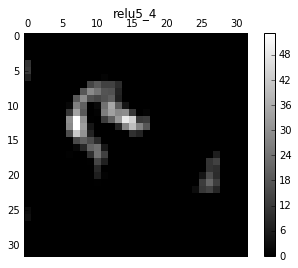

In [140]:
D_IMG_FILENAME = 'train/apple_pie/100605.jpg'
D_IMG_PATH = '/data/nv_dlcontest_dataset/'

features = converter.convertImage(converter.imread(D_IMG_PATH + D_IMG_FILENAME))

converter.drawResult(features)

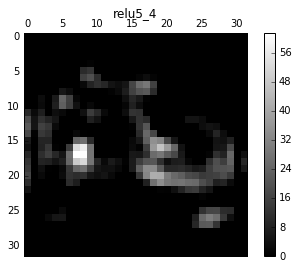

In [144]:
features = converter.convertImage(converter.imread('/data/nv_dlcontest_dataset/train/onion_rings/844469.jpg'))

converter.drawResult(features)

In [147]:
D_INPUT_IMG_DIR = D_IMG_PATH + 'train'
D_OUTPUT_IMG_DIR = D_IMG_PATH + 'train_VGG'

converter.convertImageDir(D_INPUT_IMG_DIR, D_OUTPUT_IMG_DIR, forTest=True)

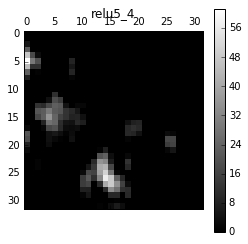

In [148]:
with open('/data/nv_dlcontest_dataset/train_VGG/scallops/664545') as f:
    mat = np.load(f)
    
    plt.figure(1)
    plt.matshow(mat[0, :, :, 0], cmap = plt.cm.gray, fignum=i+1)
    plt.title("" + layer)
    plt.colorbar()

In [149]:
with open('/data/nv_dlcontest_dataset/train_VGG/onion_rings/844469') as f:
    mat = np.load(f)
    
    plt.figure(1)
    plt.matshow(mat[0, :, :, 0], cmap = plt.cm.gray, fignum=i+1)
    plt.title("" + layer)
    plt.colorbar()

IOError: [Errno 2] No such file or directory: '/data/nv_dlcontest_dataset/train_VGG/onion_rings/844469'

## Converting start

In [24]:
D_IMG_FILENAME = 'train/apple_pie/100605.jpg'
D_IMG_PATH = '/data/nv_dlcontest_dataset/'

In [ ]:
D_INPUT_IMG_DIR = D_IMG_PATH + 'train'
D_OUTPUT_IMG_DIR = D_IMG_PATH + 'train_VGG'

converter.convertImageDir(D_INPUT_IMG_DIR, D_OUTPUT_IMG_DIR)

scallops
onion_rings
chicken_curry
french_onion_soup
dumplings
nachos
tuna_tartare
gnocchi
gyoza
bruschetta
croque_madame
edamame
grilled_salmon
sashimi
spring_rolls
risotto
prime_rib
pajeon
cannoli
soondae
doenjang_chigae
waffles
macarons
foie_gras
dakbokkeumtang
ceviche
cheese_plate
hot_dog
ojingeo_bokkeum
creme_brulee
steak
falafel
lasagna
cup_cakes
spaghetti_bolognese
omelette
filet_mignon
soondubu_jjigae
chocolate_mousse
caesar_salad
spaghetti_carbonara
peking_duck
macaroni_and_cheese
pulled_pork_sandwich
escargots
chicken_wings
takoyaki
bulgogi
donuts
samosa
miso_soup
panna_cotta
fish_and_chips
tiramisu
guacamole
lobster_roll_sandwich
pad_thai
bibimbap
deviled_eggs
churros
galchijorim
baby_back_ribs
shrimp_and_grits
red_velvet_cake
hamburger
mussels
samgyetang
sushi
tacos
greek_salad
garlic_bread
fried_rice
carrot_cake
pancakes
huevos_rancheros
nangmyeon
jjajangmyeon
jeyuk_bokkeum
chicken_quesadilla
beef_carpaccio
daegaejjim
galbijjim
lobster_bisque
grilled_cheese_sandwich
clam_c

In [14]:
D_INPUT_IMG_DIR = D_IMG_PATH + 'test'
D_OUTPUT_IMG_DIR = D_IMG_PATH + 'test_VGG'

converter.convertTestImageDir(D_INPUT_IMG_DIR, D_OUTPUT_IMG_DIR)

/data/nv_dlcontest_dataset/test_VGG
Skip: .DS_Store


In [15]:
!ls -1 /data/nv_dlcontest_dataset/test | wc -l

11565


In [16]:
!ls -1 /data/nv_dlcontest_dataset/test_VGG | wc -l

11565


In [17]:
!ls -1 /data/nv_dlcontest_dataset/train | wc -l

120
